# Преобразование признаков

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

ЗАДАНИЕ 1.

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

C:\Users\Windows\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Попробуем определить характеристики наших рядов. Посмотрим на ресемплинг (перерасчет рядов в новые временные отрезки, месячные для потребления энергии и по нефти).

In [3]:
data_m = data.resample('M').mean()

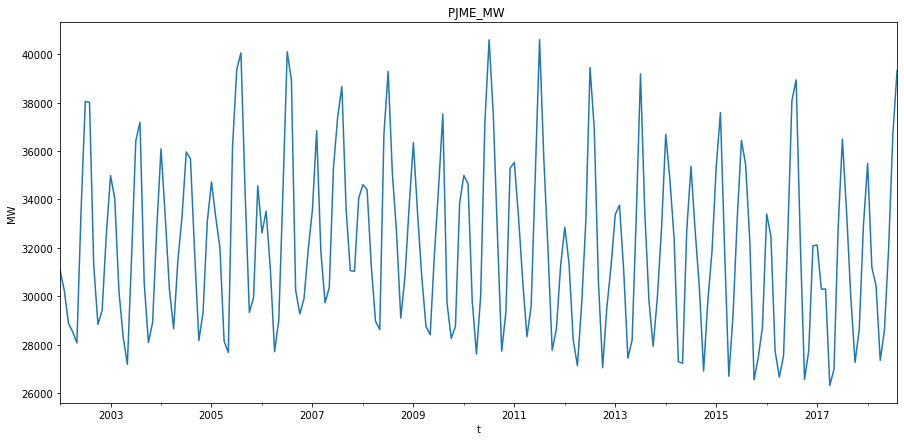

In [4]:
_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

График показывает цикличность потребления энергии. Вывод - ряд по потреблению энергии похож на стационарный без выбросов

Посмотрим на годовые графики для потребления энергии 

In [5]:
data_y = data.resample('Y').mean()

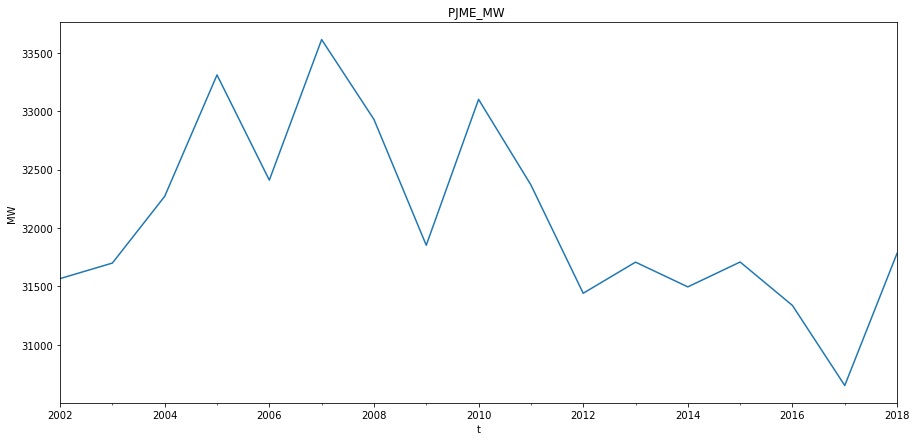

In [6]:
_ = data_y['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

График напоминают случайное явление. Можно проверить как ведут себя первые разности (x(t)-x(t-1)). Если ряд таких разностей стационарен, то можно гарантировать стационарность ряда после удаления основной его части.

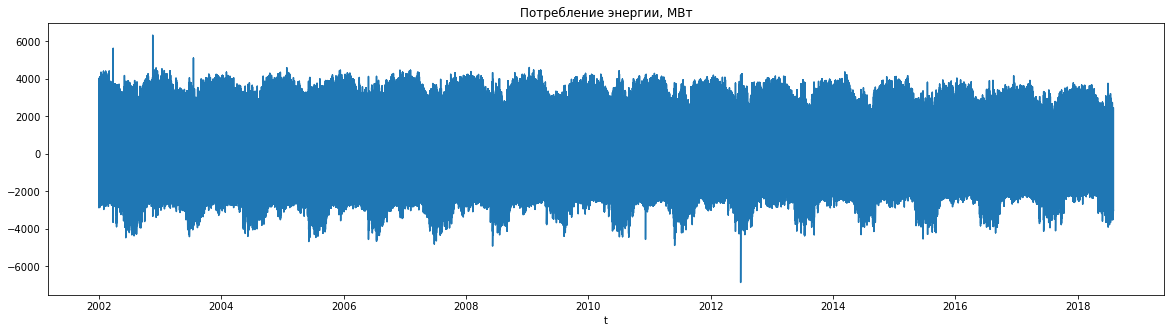

In [7]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]
plt.figure(figsize=(20,5))

plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

Вывод - потребление энергии - нестационарный процесс

Делаем тест Дики-Фуллера(ADF) с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды. 

In [8]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [9]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values[:100],regression='ct')
DF_data

(-0.9879271614271755,
 0.945717945461718,
 11,
 88,
 {'1%': -4.065513968057382,
  '5%': -3.4616143302732905,
  '10%': -3.156971502864388},
 1540.9733442182637)

In [10]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values,regression='ctt')
DF_data

(-2.5774555917296045,
 0.5247860093676764,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

Вывод: месячные средние по потреблению энергию не являются стационарными ( явные сезоны). Проверим первые разности на стационарность.

In [11]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ct')
print('коэффициент ADF для 1-й разности потребления энергии: ', DF_data_d[1])

коэффициент ADF для 1-й разности потребления энергии:  0.0


Вывод: лаги изменения потребления энергии на месячных интервалах стационарны и это - **интегрированный ряд**.
Ряд потребление энергии имеет значение DF_data[0] = -2.57 значительно больше критического для 10% (-3.57), а значит с вероятностью большей 10% не стационарен (Нуль-гипотеза отклонена). Он не имеет тренда, но есть сезоны.
Поэтому нужно разделить модель на отдельные составляющие - сезонность потребления энергии отделим от стационарных колебаний вокруг этой компоненты.
Модели предсказания стационарной и нестационарной составляющих разнличны и позволяют работать отдельно над представлением случайного и нет в наших временных рядах.

**Применим технику сглаживание**.

Будем учитывать предшествующее значение с коэффициентом памяти по формуле

**(x(i)a + (1-a)(x(n-i+1)* a + (1-a)( ...+ (1-a)(x(i-n))))** 

это - **экспоненциальное сглаживание**


In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


Text(0.5, 1.0, 'PJME_MW')

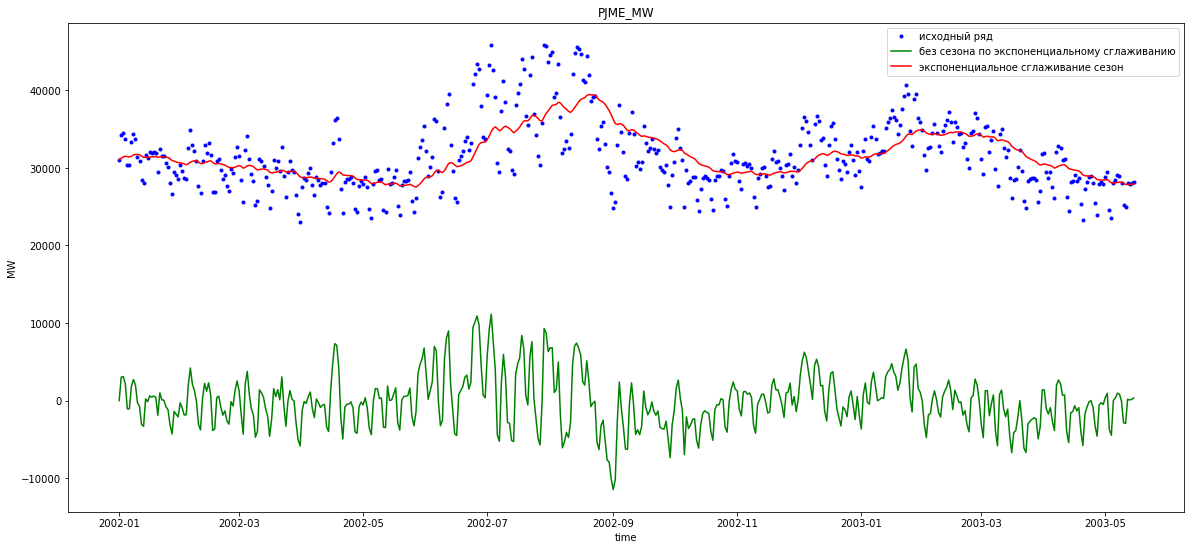

In [24]:
d_data=data.resample('D').mean()

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [14]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138577241,
 4.282974615026078e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

**Результат удаления явно сезонной составляющей для потребления энергии - стационарный ряд**

Будем использовать линейную модель, зависящую от истории - **AR - Авторегрессионную модель**, которая является сравнительно простой и оперирует параметром: гдубина регрессии - р. 

Соберем признаки для такой модели. В качестве признаков будем использовать измерения, которые делали в р предшествующие моменты времени. 

In [15]:
b_ar = d_data['PJME_MW'].values
b_s = pd.DataFrame(data = d_data[['PJME_MW']])
b_ar_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)

In [16]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,-159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,-163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,-115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,55.693138


In [17]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

Разобъем выборку на тестовую и тренировочную составляющую

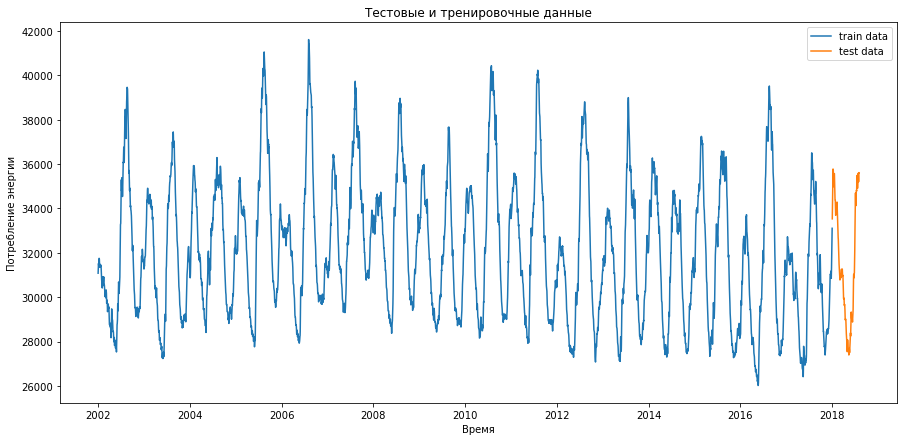

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '01-01-2018')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [19]:
print(X_train_b)


                       0             t            t1            t2  \
Date                                                                 
2002-01-01  31080.739130      0.000000      0.000000      0.000000   
2002-01-02  31239.779257  31080.739130      0.000000      0.000000   
2002-01-03  31403.384044  31239.779257  31080.739130      0.000000   
2002-01-04  31518.987759  31403.384044  31239.779257  31080.739130   
2002-01-05  31463.294621  31518.987759  31403.384044  31239.779257   
...                  ...           ...           ...           ...   
2017-12-27  31324.940035  31024.785563  30849.147084  30897.880703   
2017-12-28  31756.853450  31324.940035  31024.785563  30849.147084   
2017-12-29  32138.633694  31756.853450  31324.940035  31024.785563   
2017-12-30  32402.654093  32138.633694  31756.853450  31324.940035   
2017-12-31  32733.321388  32402.654093  32138.633694  31756.853450   

                exp_0_01      exp_0_03      exp_0_08       diff1  
Date                  

In [20]:
print(y_train_b)

[31239.77925725 31403.38404438 31518.98775883 ... 32402.65409296
 32733.32138831 33106.20740223]


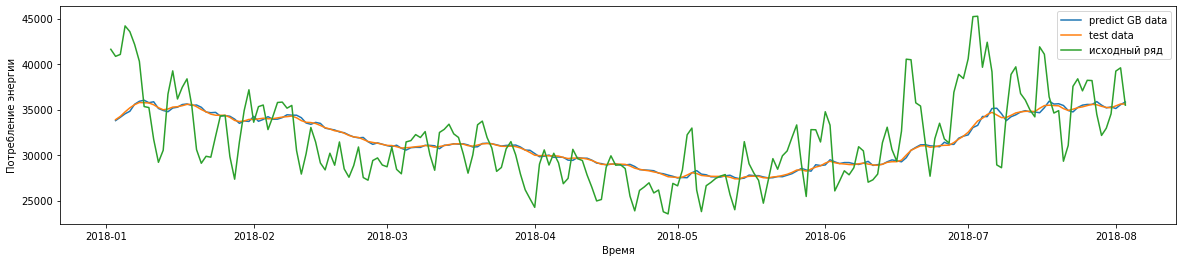

ошибка градиентного бустинга :   0.4147658760036105 %


In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-01-02':].index, b_s.loc['2018-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Анализируем корреляцию

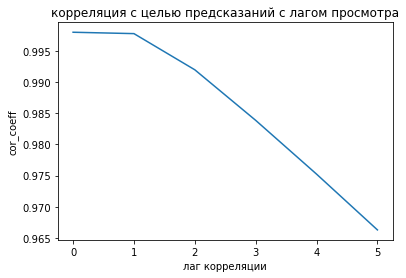

In [22]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

Выше  моделировали только сезонный процесс и на коротком интервале прогноза. 
Увеличим интервал прогноза до h=10 шагов вперед. 

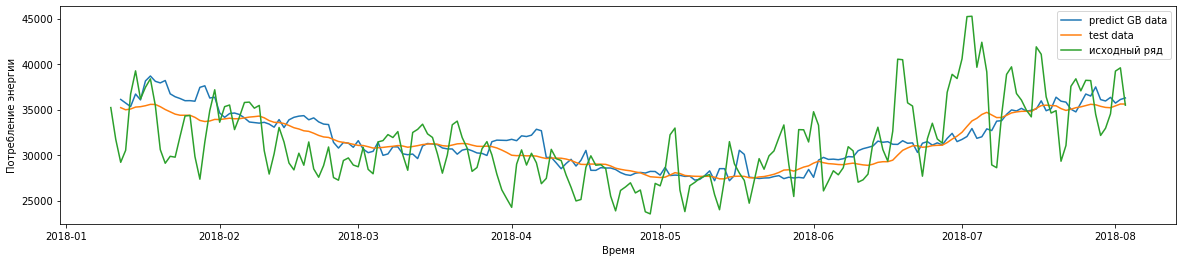

ошибка градиентного бустинга :   2.7786632133305464 %


In [23]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-01-10':].index, b_s.loc['2018-01-10':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ЗАДАНИЕ 2.

Оцените ошибку модели из п.1 .

горизонт прогноза h=1

ошибка градиентного бустинга :   0.4147658760036105 %


горизонт прогноза h=10

ошибка градиентного бустинга :   2.7786632133305464 %

ЗАДАНИЕ 3.

Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Модель авторегрессии с горизонтом прогноза h=1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее =0.41%. 

Модель авторегрессии с горизонтом прогноза h=10 работает не так хорошо. 
Значение ошибки для нее=2.78%

Вывод: при увеличении горизонта прогноза с h=1 до h=10 Модель авторегрессии будет работает в 7 раз хуже (согласно ошибке)


ЗАДАНИЕ 4.

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

а) Изменение температуры за окном .

 Зависит от длительности интервала,
 если это 1 день, то тогда тренд - увеличение с утра ко дню и уменьшение от дня к вечеру, если это год - то это сезон (времена года), если неск лет - небольшое количество - то циклы, если интервал достаточно большой - много лет, то стационарный ряд
 

б) Количество денег, которые тратят покупатели в интернет магазине.

Зависит от длительности интервала,
В течении дня - тренд, если взять год, то есть сезонность, неск лет - циклы, много лет - стационарный ряд

в) Вес растущего котенка.

Зависит от длительности интервала - неск. месяцев - тренд, неск дней - стационарный

г) Прирост объема деревьев в лесу от времени

Зависит от длительности интервала  сотни лет - стационарный ряд, неск. десятков лет - тренд, когда растет молодой лес или человеческая деятельность имеет место - вырубка леса, много десятков лет - циклы. 
